## Import depedencies and Tensorflow
#### **Restart runtime after installing to use tensorflow 2.9.2**

In [ ]:
!pip install -q tensorflow==2.9.2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import random

In [ ]:
import tensorflow as tf

print(f"Using Tensorflow {tf.__version__}")

Using Tensorflow 2.9.2


## Download dataset and test images

In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_url = "https://drive.google.com/file/d/1HRWEIr9gALYbj6ulXMbuAioYdmQ97K9Z/view?usp=sharing"
file_id = file_url.split("/")[-2] # URL id of dataset.
downloaded = drive.CreateFile({'id': file_id})
print(f"Downloading {downloaded['title']} ...")
downloaded.GetContentFile(downloaded['title'])

## Unzip dataset to "bike" and "motorbike" subfolders

In [ ]:
!mkdir /content/dataset
!unzip -q /content/{downloaded['title']} -d /content/dataset/

## Declare dataset directory and check dataset size

In [ ]:
data_dir = pathlib.Path("/content/dataset")

## Delete corrupted images
Check hex data (headers) to know if images are plain corrupted, wrong format...

In [ ]:
from struct import unpack # unpack image data

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break  


def delete_broken_image(image_dir):
  bads = []
  for img in os.listdir(image_dir):
    image = os.path.join(image_dir, img)
    image = JPEG(image) 
    try:
      image.decode()   
    except:
      bads.append(img)

  for name in bads:
    print(f"Delete {os.path.join(image_dir, name)}")
    os.remove(os.path.join(image_dir, name))

In [ ]:
subfolder = ["bike", "motorbike"]
for x in subfolder:
  delete_broken_image(os.path.join(data_dir, x))

Delete /content/dataset/bike/20220821_09_23_06_161_000_hZQaKn4zVMT2wlTW9KEEaSSmUWr1_F_2592_1944 (1).jpg
Delete /content/dataset/bike/20220819_10_34_41_006_000_hZQaKn4zVMT2wlTW9KEEaSSmUWr1_F_2592_1944.jpg
Delete /content/dataset/motorbike/2019_08_05_05_17_32_B0xS_6hHgXG_66398352_483445189138958_8195470045202604419_n_1568719912383_18787.jpg
Delete /content/dataset/motorbike/36_1498933419_1568719566728_14016.jpg
Delete /content/dataset/motorbike/Motor7svrb_zvsmallMotor.jpg
Delete /content/dataset/motorbike/96_201503220449_img_20150202_114557_1568719735476_16338.jpg
Delete /content/dataset/motorbike/70_201609113434_img20160906150355_1568719720842_16140.jpg
Delete /content/dataset/motorbike/79_414925055008472_1568719726002_16213.jpg
Delete /content/dataset/motorbike/70_a2_1_1568719423160_11994.jpg
Delete /content/dataset/motorbike/96_gia_xe_may_sym_re_nhat_2016_duoc_nguoi_tieu_dung_ua_chuong_4_1568719337886_10799.jpg
Delete /content/dataset/motorbike/9036559372_d5fd35b32b_o.jpg
Delete /cont

In [ ]:
bike_count = len(list(data_dir.glob('bike/*')))
motorbike_count = len(list(data_dir.glob('motorbike/*')))
print(f"{bike_count} bike images.\n{motorbike_count} motorbike images.")

6044 bike images.
6067 motorbike images.


## Define some hyperparameters

In [ ]:
batch_size = 16
img_height = img_width = 224

## Generate TF dataset using `image_dataset_from_directory()` method

*   Train-Val-Test split ratio is 70:25:5



In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      validation_split=0.3,
                                                      subset="training",
                                                      label_mode = "binary", 
                                                      seed=42,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 12111 files belonging to 2 classes.
Using 8478 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                    validation_split=0.3,
                                                    subset="validation",
                                                    label_mode = "binary",
                                                    seed=42,
                                                    image_size=(img_height, img_width),
                                                    batch_size=batch_size)

Found 12111 files belonging to 2 classes.
Using 3633 files for validation.


### Val-Test split ratio is 5:1.
`tf.data.experimental.cardinality`: return number of dataset batches



In [ ]:
train_batches = tf.data.experimental.cardinality(train_ds)
val_batches = tf.data.experimental.cardinality(val_ds)
test_batches = val_batches // 5

test_ds = val_ds.take(test_batches)
val_ds = val_ds.skip(test_batches)

In [ ]:
print(f'Number of train batches: {train_batches}')
print(f'Number of validation batches: {val_batches}')
print(f'Number of test batches: {test_batches}')

Number of train batches: 530
Number of validation batches: 228
Number of test batches: 45


In [ ]:
class_names = train_ds.class_names # check classes order
print(class_names)

['bike', 'motorbike']


## Visualize first images from training set

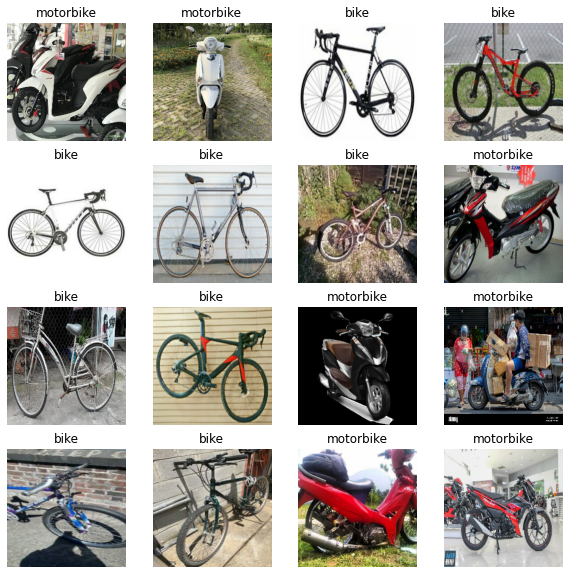

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Apply augmentation to dataset
* Use map() method to create a dataset that yields batches of augmented images.

In [ ]:
resize = tf.keras.layers.Resizing(img_height, img_width)

aug = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal"),
                          tf.keras.layers.RandomZoom(height_factor=0.1, fill_mode="nearest"),
                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode="nearest"),
                          tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest")])

## Transform data to prefetch data for faster performance 

*   Producing data is overlapped with model consuming data.
*   GPU background thread and an internal buffer are used to prefetch input data before they are requested for training model.
*   The number of elements to be prefetched are set `AUTOTUNE` to change dynamically at runtime.
*   Use `cache()` method so that the loader doesn't need to re-read the data from the file on each epoch.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def transform(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize(x), y),
                num_parallel_calls=AUTOTUNE)

  ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=10000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (aug(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = transform(train_ds, shuffle=True, augment=False)
val_ds = transform(val_ds)
test_ds = transform(test_ds)

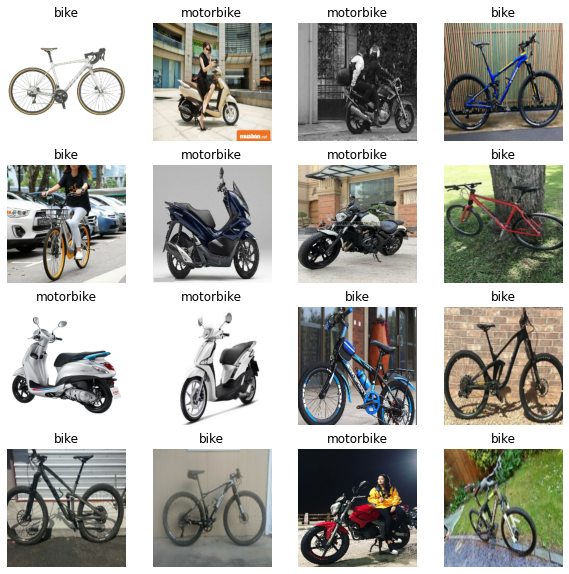

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Define model architecture
*  Use pre-trained model Mobilenetv2 as feature extraction

In [ ]:
input_shape = (img_width, img_height, 3)

backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                          weights="imagenet",
                                                          input_shape=input_shape,
                                                          pooling="avg")

# Freeze all base model layers to prevent weights update
backbone.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
backbone.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add rescaling layer to input and top classfication layer to output

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

predict_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = rescale(inputs)
x = backbone(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = predict_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_______________________________________________

## Choose optimizers and loss function for model
*   `ExponentialDecay`: Reduce learning rate during training progress with following expression `initial_learning_rate * decay_rate ^ (step / decay_steps)`

In [ ]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,
                                                          decay_steps=10 * train_batches, # reduce lr after every 10 epochs
                                                          decay_rate=0.8)

opt = tf.keras.optimizers.Adam(learning_rate=lr_decay)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # set logits to feed output of CNN to sigmoid function

model.compile(optimizer=opt,
              loss=loss,
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## Define callbacks for training progress convenience

*   `EarlyStopping`: Stop training when a monitored metric stops improving.



In [ ]:
monitor='val_loss'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                  min_delta=1e-4,
                                                  patience=5,
                                                  verbose=1,
                                                  mode='auto',
                                                  restore_best_weights=True)

In [ ]:
epochs = 100

history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/100
530/530 [==============================] - 45s 69ms/step - loss: 0.3194 - binary_accuracy: 0.8583 - val_loss: 0.1170 - val_binary_accuracy: 0.9767
Epoch 2/100
530/530 [==============================] - 16s 30ms/step - loss: 0.0868 - binary_accuracy: 0.9814 - val_loss: 0.0628 - val_binary_accuracy: 0.9897
Epoch 3/100
530/530 [==============================] - 16s 29ms/step - loss: 0.0547 - binary_accuracy: 0.9871 - val_loss: 0.0447 - val_binary_accuracy: 0.9911
Epoch 4/100
530/530 [==============================] - 16s 30ms/step - loss: 0.0407 - binary_accuracy: 0.9900 - val_loss: 0.0366 - val_binary_accuracy: 0.9911
Epoch 5/100
530/530 [==============================] - 16s 29ms/step - loss: 0.0343 - binary_accuracy: 0.9904 - val_loss: 0.0319 - val_binary_accuracy: 0.9914
Epoch 6/100
530/530 [==============================] - 16s 30ms/step - loss: 0.0300 - binary_accuracy: 0.9908 - val_loss: 0.0289 - val_binary_accuracy: 0.9918
Epoch 7/100
530/530 [=========================

### Plot the results

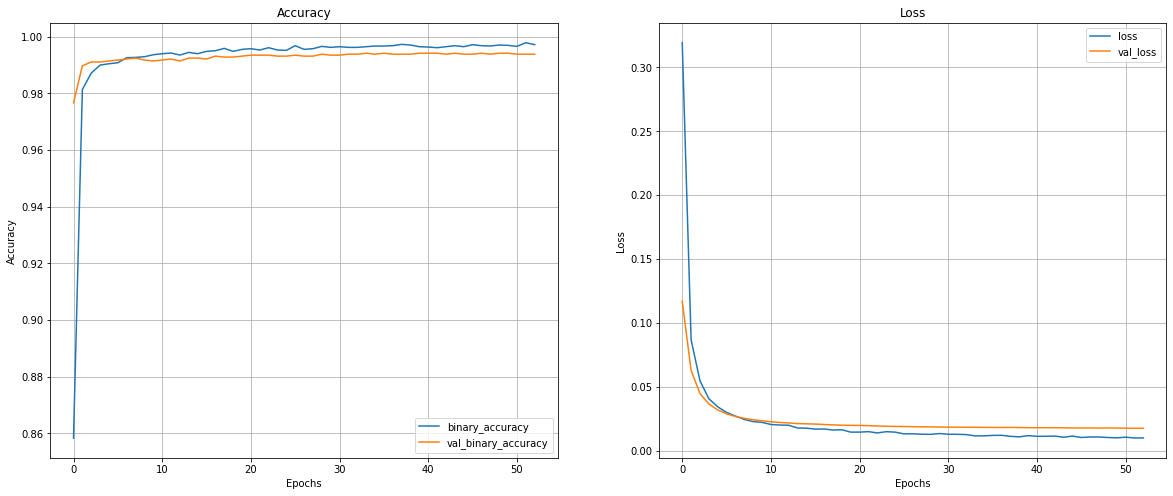

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'val_binary_accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.grid("on")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.title('Loss')
plt.grid("on")
plt.show()

### Evaluation and predictions on test set

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy :{accuracy*100:.2f}%')
print(f'Test loss :{loss*100:.2f}%')

45/45 [==============================] - 5s 86ms/step - loss: 0.0141 - binary_accuracy: 0.9917
Test accuracy :99.17%
Test loss :1.41%


Predictions:
 [0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1]
Labels:
 [0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1]


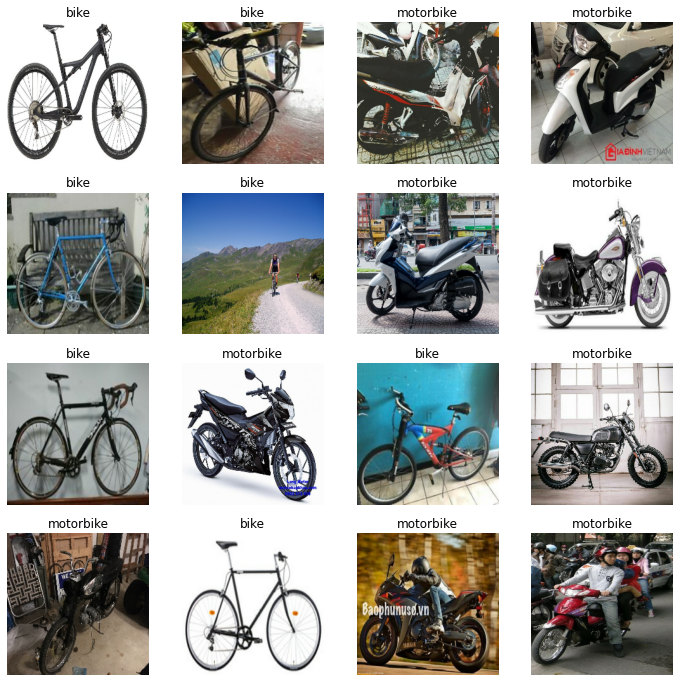

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.shuffle(10000).as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
score = tf.nn.sigmoid(predictions)
predictions_id = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions_id.numpy())
print('Labels:\n', label_batch.reshape(batch_size).astype("int"))

plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions_id[i]])
  plt.axis("off")

### Make predictions on external images directory

1/1 [==============================] - 0s 35ms/step

Predict: MOTORBIKE



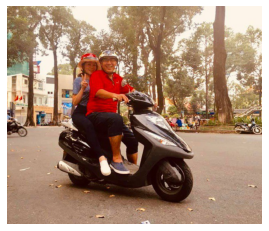

In [ ]:
test_images = pathlib.Path("/content/test")
img_list = list(test_images.glob("*"))
rnd_img = random.choice(img_list)

image = tf.keras.preprocessing.image.load_img(rnd_img, target_size=(img_width, img_height))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

score = tf.nn.sigmoid(model.predict(input_arr))
prediction = tf.where(score < 0.5, 0, 1)

if prediction == 0:
    print(f"\nPredict: BIKE\n")
else:
    print(f"\nPredict: MOTORBIKE\n")

plt.imshow(tf.keras.preprocessing.image.load_img(rnd_img))
plt.axis('off')
plt.show()